Dataset shape: (550, 41)

First 5 rows:
   city_mpg                        class  combination_mpg  cylinders  \
0        25                  midsize car               29        4.0   
1        26                  midsize car               30        4.0   
2        25  small sport utility vehicle               27        4.0   
3        26  small sport utility vehicle               29        4.0   
4        26  small sport utility vehicle               28        4.0   

   displacement drive fuel_type  highway_mpg   make     model  ...  \
0           2.5   fwd       gas           36  mazda         6  ...   
1           2.5   fwd       gas           37  mazda         6  ...   
2           2.5   fwd       gas           31  mazda  cx-5 2wd  ...   
3           2.0   fwd       gas           34  mazda  cx-5 2wd  ...   
4           2.0   fwd       gas           32  mazda  cx-5 2wd  ...   

  size_category_encoded  drivetrain_type_encoded  city_mpg_scaled  \
0                     1              

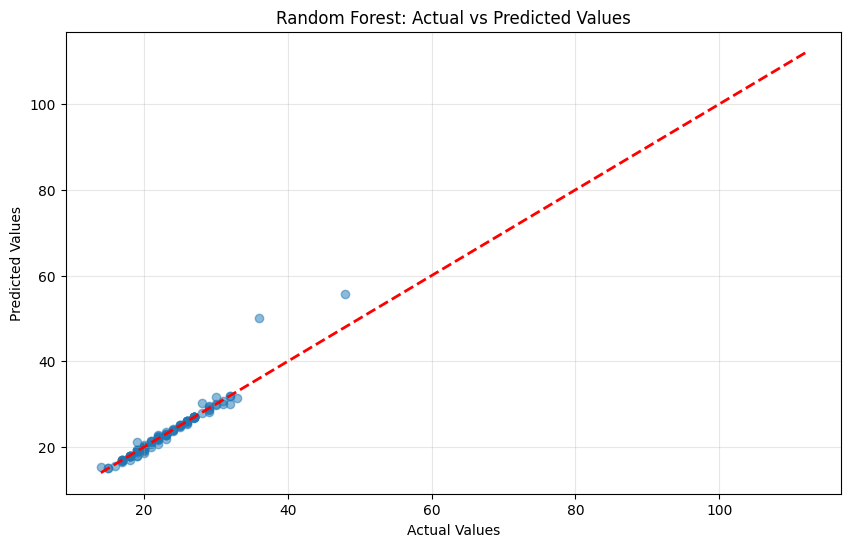

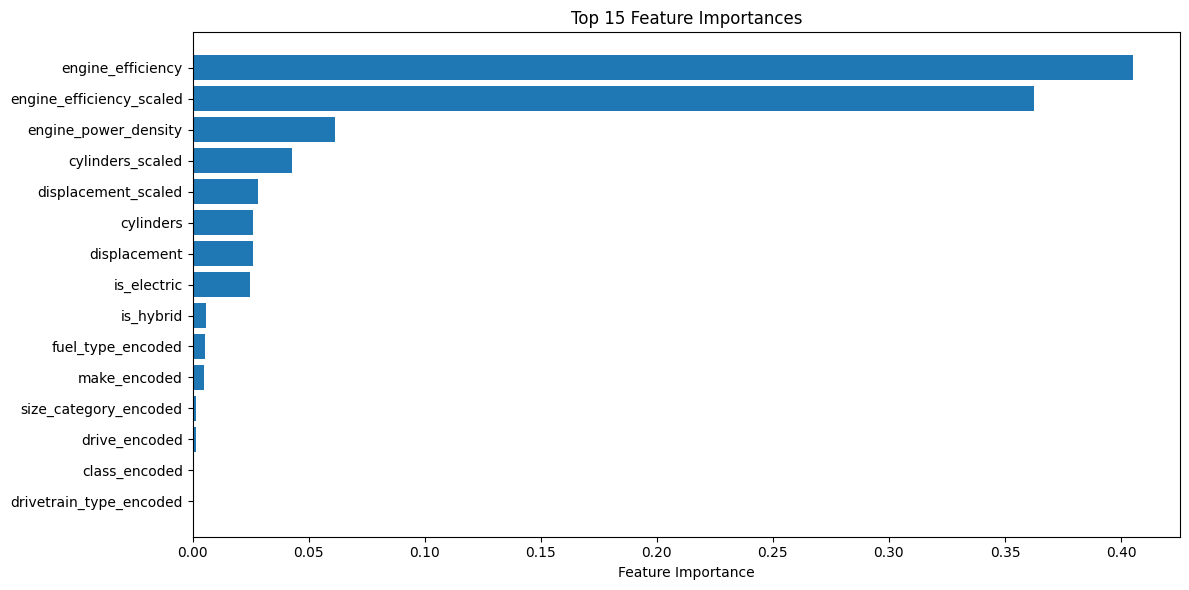

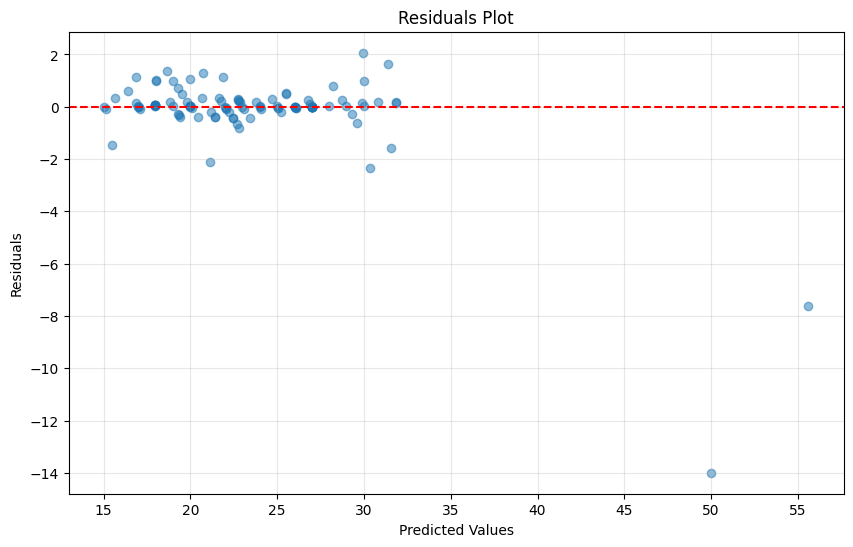

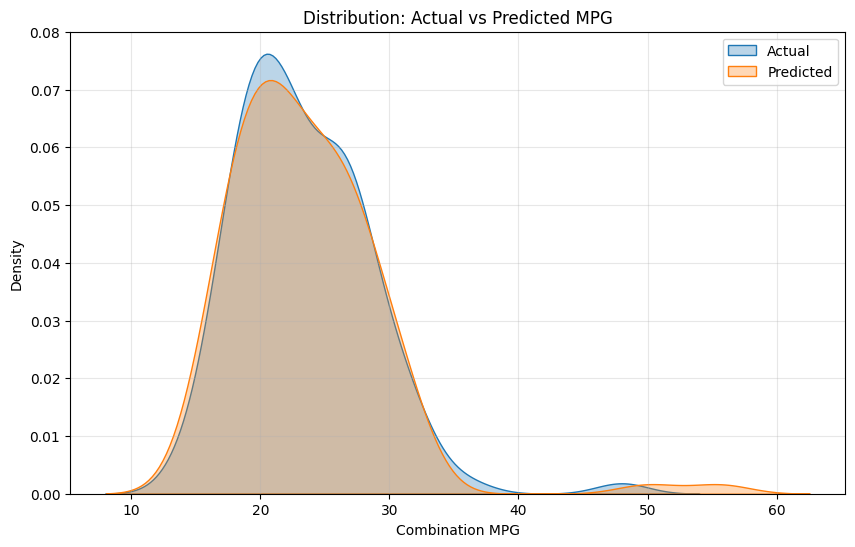


COMPARISON FOR DIFFERENT TARGET VARIABLES

TRAINING FOR TARGET: city_mpg
Features used: 25
R² Score: 0.9537
RMSE: 1.1124
Top 5 features:
                 feature  importance
       engine_efficiency    0.279216
engine_efficiency_scaled    0.263027
        cylinders_scaled    0.102631
    engine_power_density    0.097574
             is_electric    0.075677

TRAINING FOR TARGET: highway_mpg
Features used: 25
R² Score: 0.9451
RMSE: 1.2053
Top 5 features:
                 feature  importance
       engine_efficiency    0.331793
engine_efficiency_scaled    0.276461
        cylinders_scaled    0.073819
    engine_power_density    0.068050
             is_electric    0.056643

TRAINING FOR TARGET: combination_mpg
Features used: 25
R² Score: 0.9708
RMSE: 0.8723
Top 5 features:
                 feature  importance
       engine_efficiency    0.318886
engine_efficiency_scaled    0.274211
    engine_power_density    0.085878
        cylinders_scaled    0.076390
             is_electric    0.074

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Since the data is provided as a string, let's read it
import io

# Read the CSV content
df = pd.read_csv("Car Data P.csv")

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())

# Let's analyze which features are available for prediction
print("\nTarget options (continuous variables):")
continuous_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(continuous_cols[:15])  # Show first 15

# Choose target variable - let's use combination_mpg as an example
target = 'combination_mpg'
print(f"\nSelected target: {target}")

# Identify feature columns
# We'll exclude the target and other MPG-related columns to avoid data leakage
exclude_cols = [
    target,
    'city_mpg',
    'highway_mpg',
    'mpg_diff',
    'city_mpg_scaled',
    'highway_mpg_scaled',
    'combination_mpg_scaled',
    'model'  # Too many unique values
]

# Select features - using the encoded and scaled versions
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.int64, np.float64, np.int32, np.float32]]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare data
X = df[feature_cols]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=10,      # Maximum depth of each tree
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1          # Use all available cores
)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("RANDOM FOREST REGRESSOR RESULTS")
print("="*50)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Actual vs Predicted range: [{y_test.min():.1f}, {y_test.max():.1f}] vs [{y_pred.min():.1f}, {y_pred.max():.1f}]")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_regressor.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
print(feature_importance.head(10).to_string(index=False))

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualization 1: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted Values')
plt.grid(True, alpha=0.3)
plt.show()

# Visualization 2: Feature Importance
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualization 3: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.show()

# Distribution of predictions vs actual
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True, alpha=0.3)
sns.kdeplot(y_pred, label='Predicted', fill=True, alpha=0.3)
plt.xlabel('Combination MPG')
plt.ylabel('Density')
plt.title('Distribution: Actual vs Predicted MPG')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Try different target variables
def train_for_target(target_var):
    """Train Random Forest for a specific target variable"""
    print(f"\n{'='*60}")
    print(f"TRAINING FOR TARGET: {target_var}")
    print(f"{'='*60}")

    # Prepare data for this target
    exclude_for_this_target = [
        target_var,
        'city_mpg',
        'highway_mpg',
        'mpg_diff',
        'city_mpg_scaled',
        'highway_mpg_scaled',
        'combination_mpg_scaled',
        'model'
    ]

    # Don't include other MPG targets as features
    if target_var != 'city_mpg':
        exclude_for_this_target.append('city_mpg')
    if target_var != 'highway_mpg':
        exclude_for_this_target.append('highway_mpg')
    if target_var != 'combination_mpg':
        exclude_for_this_target.append('combination_mpg')

    features = [col for col in df.columns if col not in exclude_for_this_target
                and df[col].dtype in [np.int64, np.float64, np.int32, np.float32]]

    X_t = df[features]
    y_t = df[target_var]

    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_t, y_train_t)

    y_pred_t = rf.predict(X_test_t)

    mse_t = mean_squared_error(y_test_t, y_pred_t)
    rmse_t = np.sqrt(mse_t)
    r2_t = r2_score(y_test_t, y_pred_t)

    print(f"Features used: {len(features)}")
    print(f"R² Score: {r2_t:.4f}")
    print(f"RMSE: {rmse_t:.4f}")

    # Top 5 features
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False).head(5)

    print("Top 5 features:")
    print(importance_df.to_string(index=False))

    return r2_t, rmse_t

# Test on different targets
print("\n" + "="*60)
print("COMPARISON FOR DIFFERENT TARGET VARIABLES")
print("="*60)

targets_to_try = ['city_mpg', 'highway_mpg', 'combination_mpg', 'engine_efficiency']
results = []

for t in targets_to_try:
    if t in df.columns:
        r2_score_val, rmse_val = train_for_target(t)
        results.append({
            'Target': t,
            'R²': r2_score_val,
            'RMSE': rmse_val
        })

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY OF RESULTS")
print("="*60)
print(results_df.to_string(index=False))